In [2]:
import pandas as pd
import numpy as np

def read_files():
    files = ['dataset/file_3_Mar18_Output_1_1.csv', 
             'dataset/file_3_Mar18_Output_1_2.csv', 
             'dataset/file_3_Mar18_Output_1_3.csv', 
             'dataset/file_3_Mar18_Output_1_4.csv', 
             'dataset/file_3_Mar18_Output_1_5.csv', 
             'dataset/file_3_Mar18_Output_1_6.csv', 
             'dataset/file_4_Mar18_Output_1_1.csv', 
             'dataset/file_4_Mar18_Output_1_2.csv', 
             'dataset/file_4_Mar18_Output_1_3.csv', 
             'dataset/file_4_Mar18_Output_1_4.csv', 
             'dataset/file_4_Mar18_Output_1_5.csv', 
             'dataset/file_4_Mar18_Output_1_6.csv']
    data = pd.DataFrame()
    for file in files:
        df = pd.read_csv(file)
        data = pd.concat([data, df])
    return data

In [3]:
data = read_files()

In [18]:
xl = pd.ExcelFile('dataset/U of I IVR code data dictionary(updated).xlsx')
mos_sheet = xl.parse('mos')
mos_sheet.head()

,Code,IVR Call Reason for IVR Call Reporting
0,AA,Activation
1,AG,Transferred from agent
2,AL,Account lookup
3,AP,Address phone change
4,AR,APR Information


In [19]:
data['mos'].head()

0                IA PP TR
1          IA BA TS nl TR
2    IA AA BA MR nl PT TR
3                   IA BA
4       IA BA TS nl mm TR
Name: mos, dtype: object

In [20]:
# Parsing and Mapping the MOS values

mos_mapping = dict(zip(mos_sheet['Code'], mos_sheet['IVR Call Reason for IVR Call Reporting']))

def map_codes_to_descriptions(code_sequence):
    codes = code_sequence.split()  # Split the sequence into individual codes
    descriptions = [mos_mapping.get(code, "Unknown") for code in codes]  # Map each code to its description
    return descriptions


data['mos_descriptions'] = data['mos'].apply(map_codes_to_descriptions)
data[['mos', 'mos_descriptions']].head()

,mos,mos_descriptions
0,IA PP TR,"[Identification and authentication, PBP Predic..."
1,IA BA TS nl TR,"[Identification and authentication, Account Su..."
2,IA AA BA MR nl PT TR,"[Identification and authentication, Activation..."
3,IA BA,"[Identification and authentication, Account Su..."
4,IA BA TS nl mm TR,"[Identification and authentication, Account Su..."


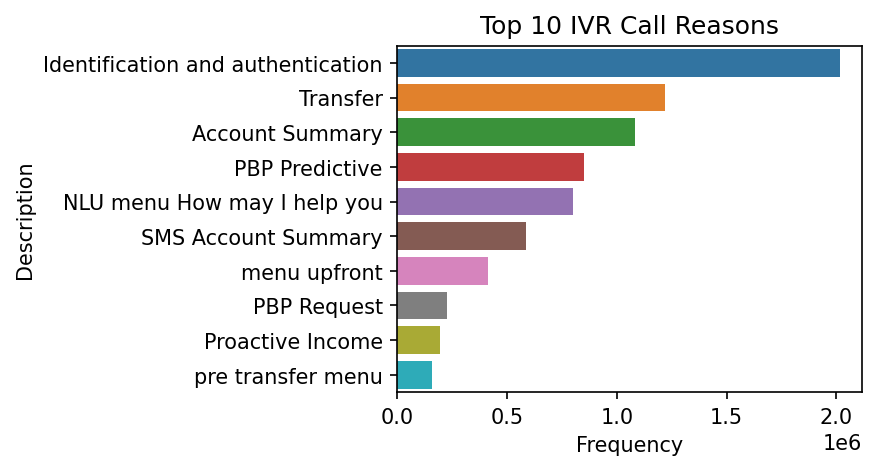

,Description,Frequency
0,Identification and authentication,2017281
2,Transfer,1219242
3,Account Summary,1084149
1,PBP Predictive,849832
5,NLU menu How may I help you,800678
4,SMS Account Summary,585427
16,menu upfront,411732
7,PBP Request,224529
14,Proactive Income,193155
10,pre transfer menu,155707


In [23]:
# Frequency Analysis

from collections import Counter
flat_list_descriptions = [item for sublist in data['mos_descriptions'].tolist() for item in sublist]
description_frequencies = Counter(flat_list_descriptions)
df_frequencies = pd.DataFrame(description_frequencies.items(), columns=['Description', 'Frequency']).sort_values(by='Frequency', ascending=False)


# plot df_frequencies
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 3), dpi=150)
sns.barplot(x='Frequency', y='Description', data=df_frequencies.head(10))
plt.title('Top 10 IVR Call Reasons')
plt.show()

df_frequencies.head(10)

### **First Step: Filtering Calls that End with TRANSFER**

In [24]:
transferred_calls_df = data[data['mos'].str.endswith('TR')]
transferred_calls_df.info(), transferred_calls_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1203551 entries, 0 to 144164
Data columns (total 41 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   timestamp_call_key                 1203551 non-null  object 
 1   retailer_code                      1203551 non-null  object 
 2   serial                             1203551 non-null  int64  
 3   reason                             1203551 non-null  object 
 4   mos                                1203551 non-null  object 
 5   resolved                           1203551 non-null  object 
 6   no_of_accounts_with_syf_13_march   1200746 non-null  float64
 7   account_balance_13_march           1132210 non-null  float64
 8   delinquency_history_13_march       1203551 non-null  object 
 9   account_open_date_13_march         1203551 non-null  object 
 10  account_status_13_march            48597 non-null    object 
 11  card_activation_status_13

(None,
       timestamp_call_key retailer_code       serial reason  \
 0  240315173250 DAL1OA3M             D  10010009499     PP   
 1  240315124742 DAL15XHK             E  10006021998     BA   
 2  240317114237 DAL3BLK6             J  10016007830     PT   
 4  240314145902 DAL68RYS             I  10013002037     BA   
 5  240314151323 PHX4I30S             I  10013002037     PS   
 
                           mos  resolved  no_of_accounts_with_syf_13_march  \
 0                    IA PP TR  resolved                               1.0   
 1              IA BA TS nl TR     floor                               2.0   
 2        IA AA BA MR nl PT TR  resolved                              12.0   
 4           IA BA TS nl mm TR     floor                               6.0   
 5  IA BA TS nl PS nl mt RS TR     floor                               6.0   
 
    account_balance_13_march delinquency_history_13_march  \
 0                       NaN                         [00]   
 1                   

In [26]:
from scipy.stats import chi2_contingency

numerical_cols = ['no_of_accounts_with_syf_13_march', 'account_balance_13_march', 'eservice_ind_13_march', 'auto_pay_enrolled_status_13_march', 'no_of_accounts_with_syf_18_march', 'account_balance_18_march', 'eservice_ind_18_march', 'auto_pay_enrolled_status_18_march']
numerical_correlations = transferred_calls_df[numerical_cols].corr(method='spearman')

contingency_table = pd.crosstab(data['resolved'], data['mos'].str.endswith('TR'))
chi2, p, dof, expected = chi2_contingency(contingency_table)

numerical_correlations, contingency_table, p


(                                   no_of_accounts_with_syf_13_march  \
 no_of_accounts_with_syf_13_march                           1.000000   
 account_balance_13_march                                  -0.005983   
 eservice_ind_13_march                                      0.032919   
 auto_pay_enrolled_status_13_march                          0.008939   
 no_of_accounts_with_syf_18_march                           0.999063   
 account_balance_18_march                                  -0.005090   
 eservice_ind_18_march                                      0.030012   
 auto_pay_enrolled_status_18_march                          0.008210   
 
                                    account_balance_13_march  \
 no_of_accounts_with_syf_13_march                  -0.005983   
 account_balance_13_march                           1.000000   
 eservice_ind_13_march                             -0.051448   
 auto_pay_enrolled_status_13_march                  0.024816   
 no_of_accounts_with_syf_18_ma

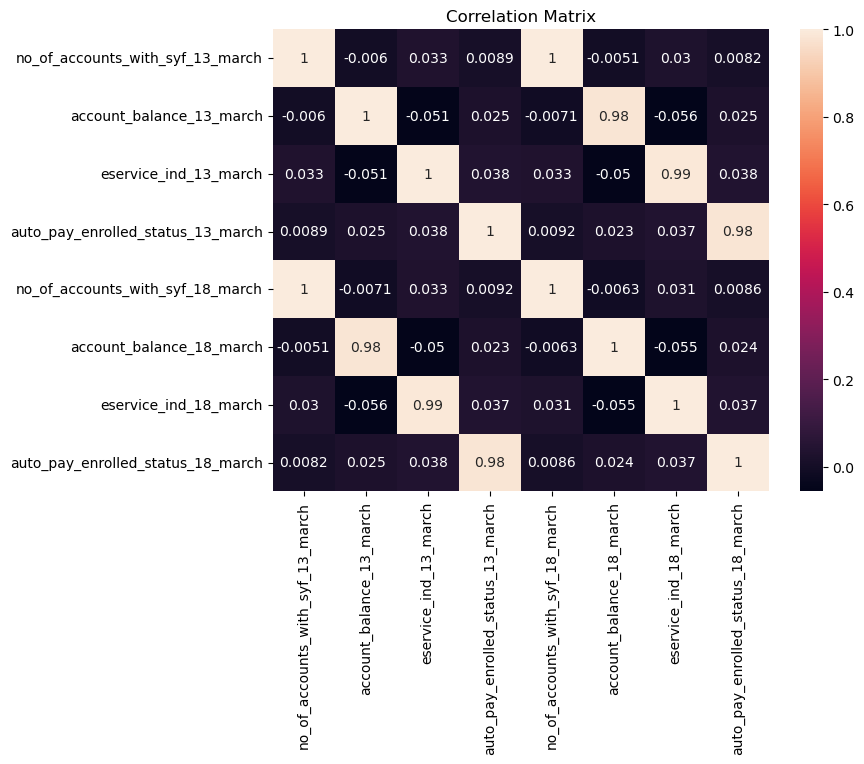

In [32]:
# Help me visualize those numerical correlations
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(numerical_correlations, annot=True)
plt.title('Correlation Matrix')
plt.show()


- People with several accounts gets transferred more frequently than others.
- People with an account balance are more likely to be transferred.

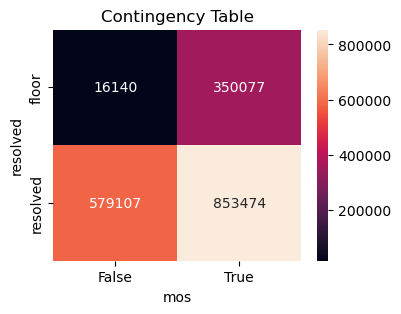

In [37]:
# Help me visualize the contingency table
plt.figure(figsize=(4, 3), dpi=100)
sns.heatmap(contingency_table, annot=True, fmt='d')
plt.title('Contingency Table')
plt.show()

## **Initial Insights**

In [43]:
# Clean Dataset
non_numeric_attributes = [
    'card_activation_status_13_march',
    'account_status_13_march',
    'ebill_enrolled_status_13_march',
    'delinquency_history_13_march'
]

# Display unique values for these non-numeric attributes to understand their categories
non_numeric_values = {attribute: transferred_calls_df[attribute].unique() for attribute in non_numeric_attributes}
non_numeric_values

{'card_activation_status_13_march': array(['0', '8', '7', ' '], dtype=object),
 'account_status_13_march': array([nan, 'F', 'E', 'A', 'Z', 'I', 'C', 'L', 'U', 'B'], dtype=object),
 'ebill_enrolled_status_13_march': array(['E', ' ', 'L', 'B', nan, 'D'], dtype=object),
 'delinquency_history_13_march': array(['[00]', '[03]', '[20]', '[02]', '[22]', '[32]', '[43]', '[54]',
        '[76]', '[23]', '[08]', '[88]', '[05]', '[56]', '[04]', '[06]',
        '[33]', '[65]', '[35]', '[07]', '[48]', '[24]', '[87]', '[44]',
        '[34]', '[55]', '[46]', '[47]', '[66]', '[25]', '[26]', '[30]',
        '[58]', '[37]', '[68]', '[57]', '[45]', '[36]', '[77]', '[67]',
        '[78]', '[27]', '[40]', '[53]', '[42]'], dtype=object)}

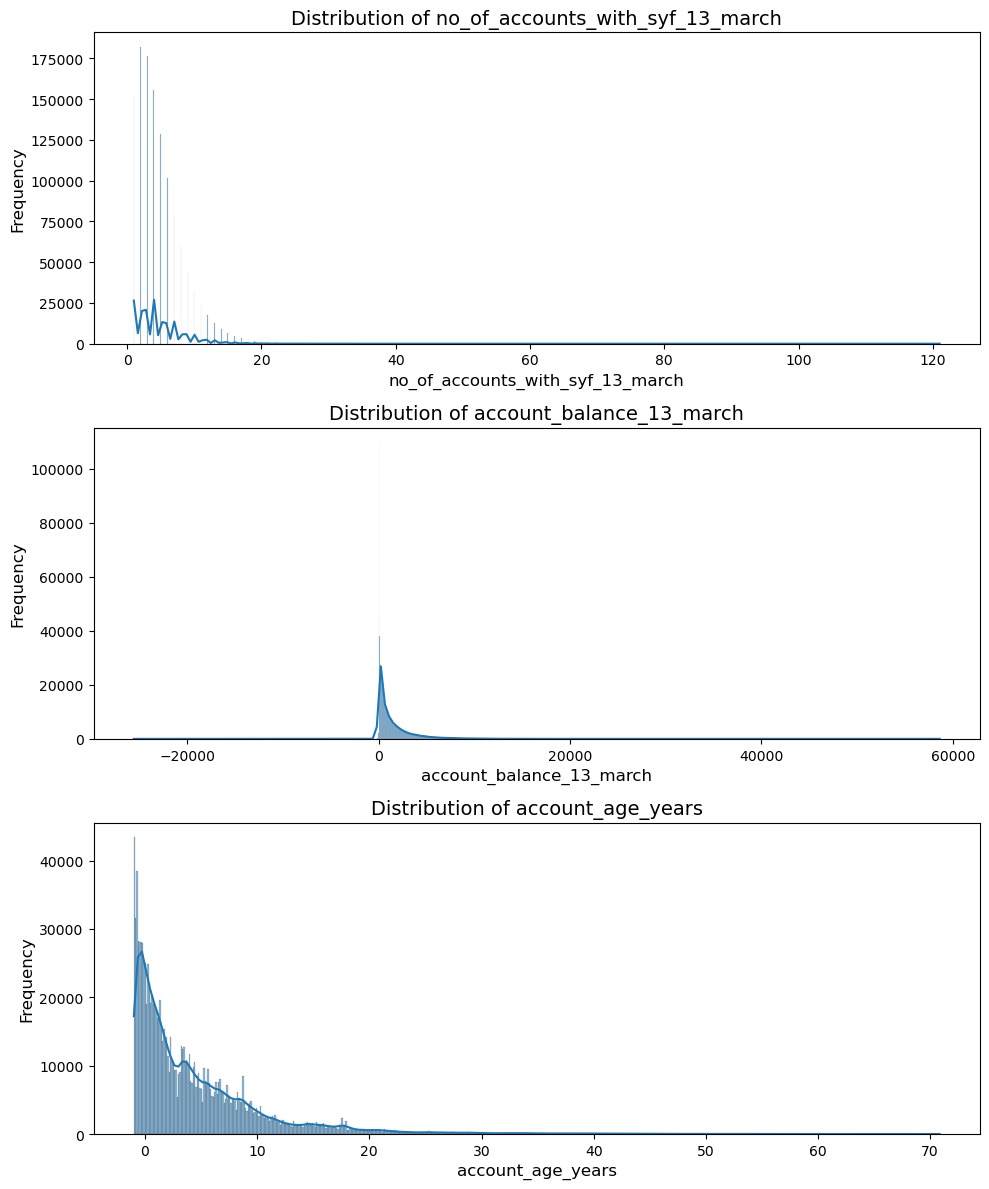

In [49]:
# Define continuous and categorical attributes after encoding.
continuous_attributes = [
    'no_of_accounts_with_syf_13_march', 
    'account_balance_13_march', 
    'account_age_years'
]

categorical_attributes_encoded = [
    attribute + '_encoded' for attribute in non_numeric_attributes
]

# Visualize continuous attributes with distribution plots.
fig, axes = plt.subplots(nrows=len(continuous_attributes), ncols=1, figsize=(10, 4 * len(continuous_attributes)), dpi=100)
for i, attribute in enumerate(continuous_attributes):
    sns.histplot(transferred_calls_df[attribute], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {attribute}', fontsize=14)
    axes[i].set_xlabel(attribute, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

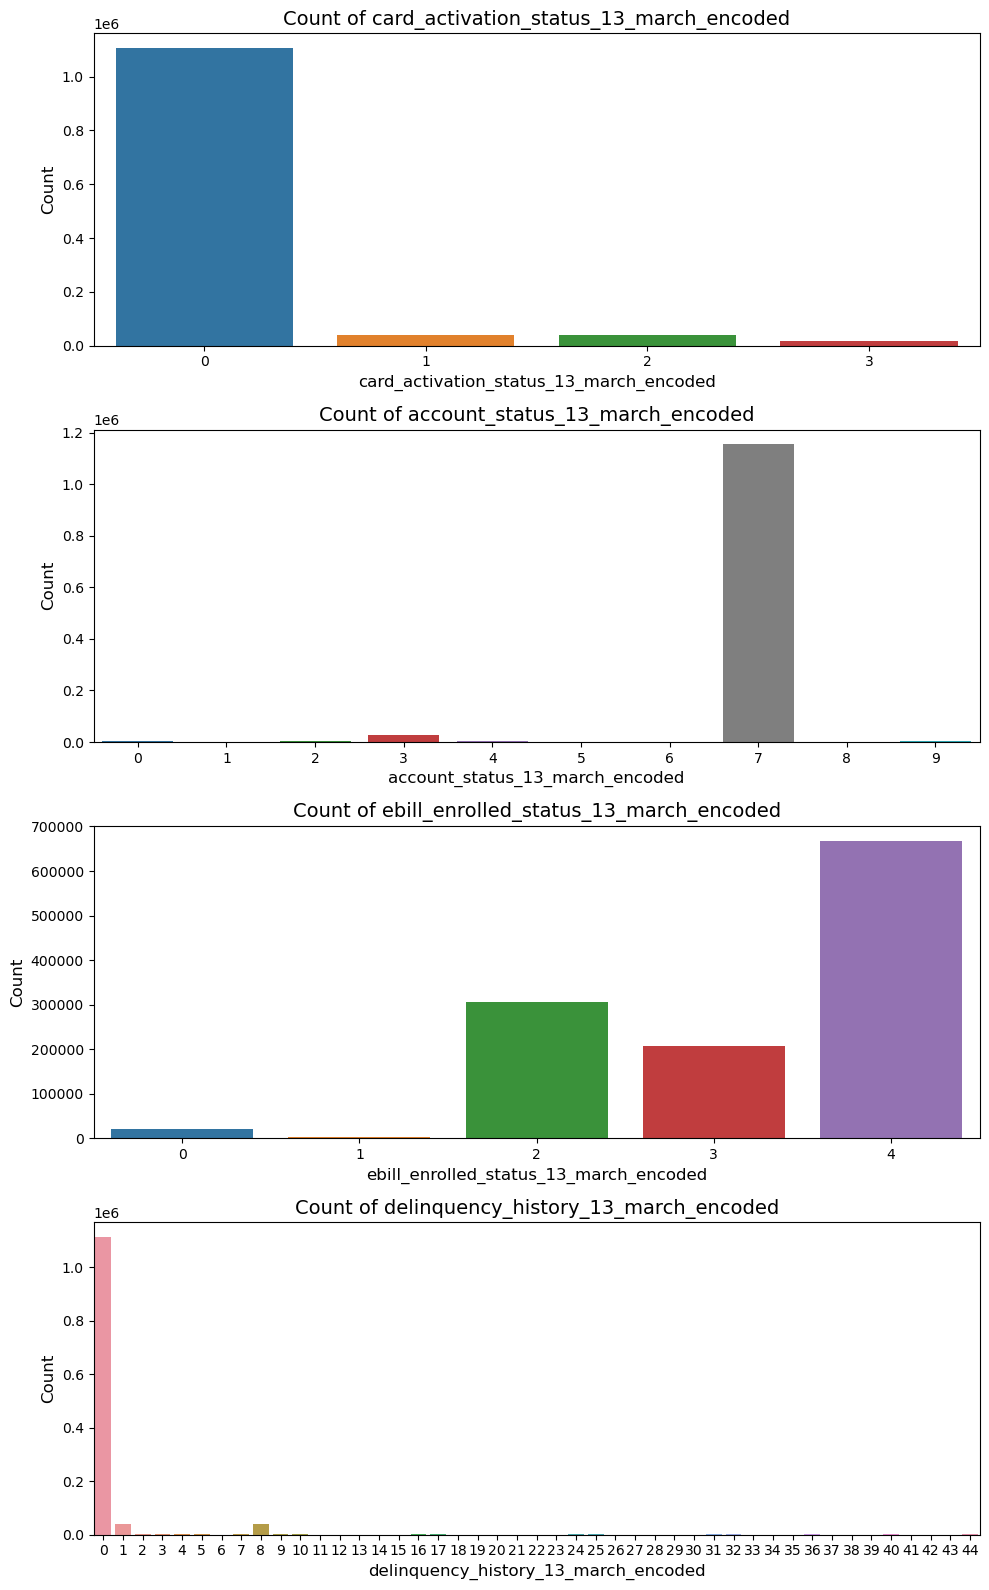

In [50]:
# Visualize categorical attributes with count plots.
fig, axes = plt.subplots(nrows=len(categorical_attributes_encoded), ncols=1, figsize=(10, 4 * len(categorical_attributes_encoded)), dpi=100)
for i, attribute in enumerate(categorical_attributes_encoded):
    sns.countplot(x=transferred_calls_df[attribute], ax=axes[i])
    axes[i].set_title(f'Count of {attribute}', fontsize=14)
    axes[i].set_xlabel(attribute, fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

In [48]:
# Show a sample of the encoded categorical attributes
transferred_calls_df[categorical_attributes_encoded].sample(10)

,card_activation_status_13_march_encoded,account_status_13_march_encoded,ebill_enrolled_status_13_march_encoded,delinquency_history_13_march_encoded
58729,0,7,3,0
47709,0,7,4,8
51143,0,7,1,9
4485,0,7,4,0
27535,0,7,4,0
85081,0,3,1,32
120107,0,7,3,0
39591,0,7,4,0
89482,0,7,4,0
143463,0,7,4,0


In [59]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

In [66]:
data['mos'].str.endswith('TR').value_counts()

True     1203551
False     595247
Name: mos, dtype: int64